### Importing Libraries

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import os

import seaborn as sns

2024-04-17 14:48:16.446446: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-17 14:48:16.487623: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 14:48:17.529737: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Konfiguration Settings

In [3]:
image_size = (250, 250)
batch_size = 32

### Data Preprocessing

In [4]:
path_with_sign = 'data/y'
path_without_sign = 'data/n'

In [5]:

def apply_canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    tight = cv2.Canny(blurred, 140, 160)
    tight = cv2.resize(tight, image_size)
    tight = np.expand_dims(tight, axis=-1)
    
    return tight

In [6]:
def apply_morphology(image, target_size=(250, 250)):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 190, 210, cv2.THRESH_BINARY)
    
    kernel = np.ones((5,5), np.uint8)
    
    dilated = cv2.dilate(thresh, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    
    image = cv2.resize(eroded, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

In [7]:
def black_and_white(image, target_size=(250, 250)):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, target_size)
    image = np.expand_dims(image, axis=-1)
    return image

In [8]:
def load_images_from_folder(folder, label, target_size, type='normal'):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        try:             
            img = cv2.imread(img_path)
            if type == 'canny':
                img = apply_canny(img)
            elif type == 'morphology':
                img = apply_morphology(img, target_size)
            elif type == 'normal':
                img = black_and_white(img, target_size)
            else:    
                raise ValueError(f"Unbekannter Typ '{type}'")
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Fehler beim Laden des Bildes {img_path}: {e}")
    return np.array(images), np.array(labels)

In [9]:
images_with_sign_canny, labels_with_sign_canny = load_images_from_folder(path_with_sign, 1, image_size, type='canny')
images_without_sign_canny, labels_without_sign_canny = load_images_from_folder(path_without_sign, 0, image_size, type='canny')

images_with_sign_morphology, labels_with_sign_morphology = load_images_from_folder(path_with_sign, 1, image_size, type='morphology')
images_without_sign_morphology, labels_without_sign_morphology = load_images_from_folder(path_without_sign, 0, image_size, type='morphology')

images_with_sign_normal, labels_with_sign_normal = load_images_from_folder(path_with_sign, 1, image_size, type='normal')
images_without_sign_normal, labels_without_sign_normal = load_images_from_folder(path_without_sign, 0, image_size, type='normal')


images_with_sign_canny = np.array(images_with_sign_canny)
images_without_sign_canny = np.array(images_without_sign_canny)
images_with_sign_morphology = np.array(images_with_sign_morphology)
images_without_sign_morphology = np.array(images_without_sign_morphology)
images_with_sign_normal = np.array(images_with_sign_normal)
images_without_sign_normal = np.array(images_without_sign_normal)

images_with_sign = np.concatenate((images_with_sign_canny, images_with_sign_morphology, images_with_sign_normal), axis=-1)
images_without_sign = np.concatenate((images_without_sign_canny, images_without_sign_morphology, images_without_sign_normal), axis=-1)
labels_with_sign = np.array(labels_with_sign_canny)
labels_without_sign = np.array(labels_without_sign_canny)

all_images = np.concatenate((images_with_sign, images_without_sign), axis=0)
all_labels = np.concatenate((labels_with_sign, labels_without_sign), axis=0)

print("Shape of all_images tensor:", all_images.shape)
print("Shape of all_labels tensor:", all_labels.shape)

Shape of all_images tensor: (1456, 250, 250, 3)
Shape of all_labels tensor: (1456,)


### Data Normalization

In [10]:
all_images = all_images.astype('float32') / 255.0
all_images.shape

(1456, 250, 250, 3)

In [11]:
namelabels = {0: 'ohneHaifisch', 1: 'mitHaifisch'}
def show_image(image, label):
    plt.imshow(image, cmap='gray')
    plt.title(namelabels[label])
    plt.show()

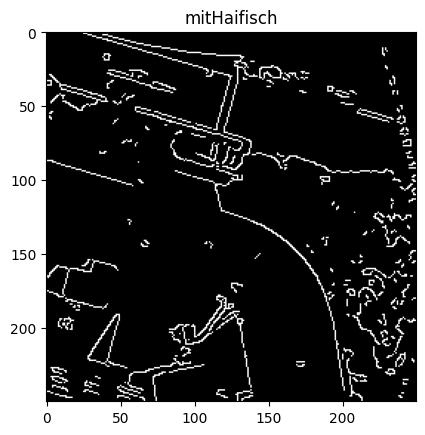

In [12]:
show_image(images_with_sign_canny[3], labels_with_sign_canny[3])

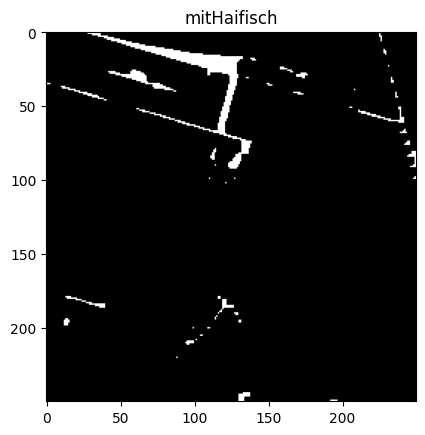

In [13]:
show_image(images_with_sign_morphology[3], labels_with_sign_morphology[3])

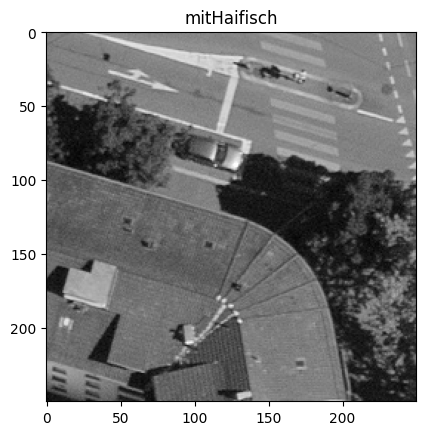

In [14]:
show_image(images_with_sign_normal[3], labels_with_sign_normal[3])

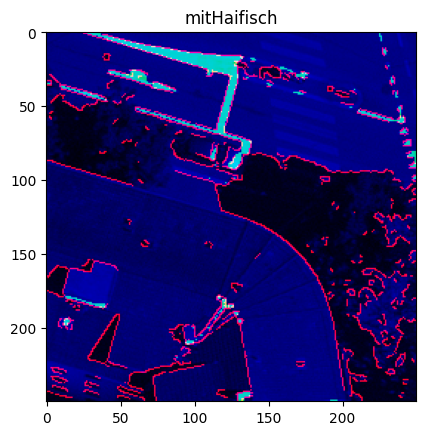

In [15]:
show_image(all_images[3], all_labels[3])

### Data Splitting

In [16]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=42)

In [17]:
train_images.shape, test_images.shape

((1164, 250, 250, 3), (292, 250, 250, 3))

In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator()

In [19]:
train_generator = train_datagen.flow(train_images, train_labels, batch_size=batch_size)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=batch_size)

### Vortrainiertes Modell

In [20]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=None)
base_model.trainable = False

/tmp/ipykernel_1114919/3706879152.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=None)
2024-04-17 14:48:32.025391: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c0:00.0, compute capability: 8.0


In [21]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x) 

In [22]:
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
# model.summary()

In [25]:
history = model.fit(
    train_images, train_labels,
    batch_size=batch_size,
    epochs=20,
    validation_split=0.10
)


Epoch 1/20


I0000 00:00:1713358121.546039 1115380 service.cc:145] XLA service 0x7f4bd0041240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713358121.546133 1115380 service.cc:153]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-04-17 14:48:41.799356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-17 14:48:42.768607: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1713358125.179587 1115663 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1782', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1713358125.325091 1115660 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1782', 228 bytes spill stores, 228 bytes spill loads



 5/33 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3675 - loss: 4.2066

I0000 00:00:1713358130.437839 1115380 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4900 - loss: 4.0619

I0000 00:00:1713358134.317620 1115785 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1782', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1713358134.409708 1115781 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1782', 224 bytes spill stores, 224 bytes spill loads



33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.4921 - loss: 4.0582

I0000 00:00:1713358144.285208 1116013 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1203', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1713358144.440907 1116017 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1203', 224 bytes spill stores, 224 bytes spill loads



33/33 ━━━━━━━━━━━━━━━━━━━━ 32s 550ms/step - accuracy: 0.4940 - loss: 4.0547 - val_accuracy: 0.5385 - val_loss: 3.7824
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6430 - loss: 3.7229 - val_accuracy: 0.5812 - val_loss: 3.6923
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7019 - loss: 3.5589 - val_accuracy: 0.6154 - val_loss: 3.6021
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7454 - loss: 3.4371 - val_accuracy: 0.6239 - val_loss: 3.5002
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7543 - loss: 3.3491 - val_accuracy: 0.6838 - val_loss: 3.3965
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7980 - loss: 3.2170 - val_accuracy: 0.7179 - val_loss: 3.3098
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8368 - loss: 3.1515 - val_accuracy: 0.7179 - val_loss: 3.2325
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8149 - loss: 3.0687 - val_accuracy: 0.7436 - val_loss: 

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Testgenauigkeit: {test_acc:.4f}, Testverlust: {test_loss:.4f}")

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8072 - loss: 2.4239

I0000 00:00:1713358164.322461 1119030 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1203', 4 bytes spill stores, 4 bytes spill loads



10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.8092 - loss: 2.4224
Testgenauigkeit: 0.8185, Testverlust: 2.4154


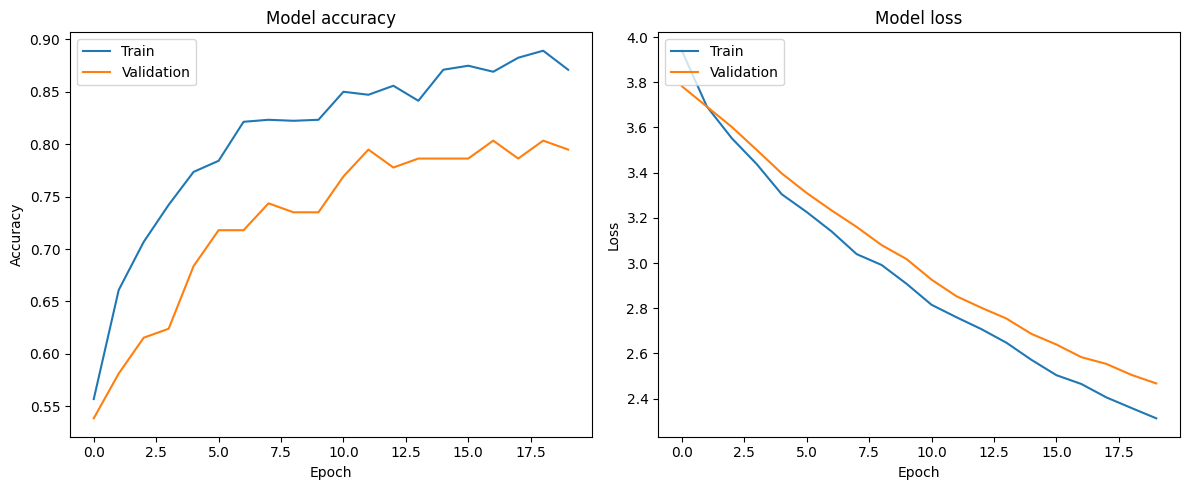

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 328ms/step
              precision    recall  f1-score   support

           0       0.84      0.79      0.81       145
           1       0.80      0.85      0.83       147

    accuracy                           0.82       292
   macro avg       0.82      0.82      0.82       292
weighted avg       0.82      0.82      0.82       292



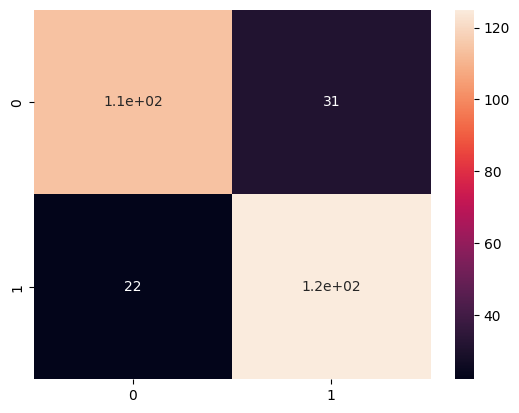

In [28]:
predictions = model.predict(test_images)
predictions = (predictions > 0.5)

print(classification_report(test_labels, predictions))

cm = confusion_matrix(test_labels, predictions)
sns.heatmap(cm, annot=True)

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


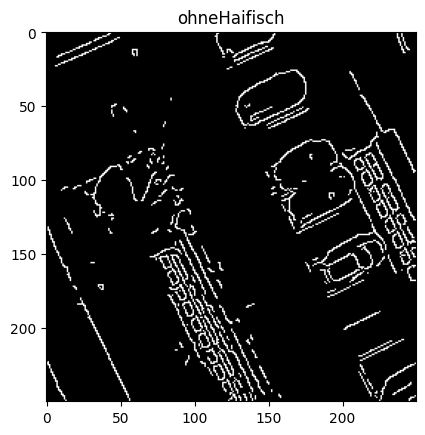

Vorhersage: 0.0038


In [29]:
#predict single image on my model
def predict_image(image):
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    prediction = model.predict(image)
    return prediction

image = test_images[1]
label = test_labels[1]
prediction = predict_image(image)
show_image(image[:,:,0], label)


